Hi.

This is an apartment on sale data downloaded from https://www.halooglasi.com/ . Data was downloaded in late summer in August 2019., so it is outdated and it's only used for fun and data analysis.

In the future, I plan to buy an apartment, and that's why I decided to explore (done in Belgrade apartments part 1). 
I used this data to practice a few machine learning algorithms for predicting Price, given the data about the apartment in Belgrade (done in Belgrade apartments part 2).

In [1]:
import pandas as pd
import numpy as np
import sqlite3

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

In [2]:
dat = sqlite3.connect('C:/Users/User/Desktop/Case Study Belgrade appartmants/apartments-sale-total.sqlite')
data=pd.read_sql_query('select * from apartments', dat)
data.head()

,id,accommodation_type,address,advertiser,city,description,location,municipality,number_of_rooms,price,...,balcony,intercom,lift,parking,telephone,internet,katv,garage,basement,loggia
0,1,Stan,Bulevar Mihajla Pupina,Agencija,Beograd,Stan se nalazi u Bloku 30 i pozicioniran je bl...,Blok 30 (B92),Opština Novi Beograd,2,119,...,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,None
1,2,Stan,Antifašističke borbe,Agencija,Beograd,Stan na odličnoj lokaciji. Nalazi se u Bloku 2...,Blok 22,Opština Novi Beograd,2,149.5,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,None
2,3,Stan,Jurija Gagarina,Agencija,Beograd,"Dvosoban stan u Belvilu od 60m2 sa terasom, 5/...",Blok 67 (Belvil),Opština Novi Beograd,2,136,...,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,None
3,4,Stan,Uroša Martinovića,Agencija,Beograd,U prilici smo da vam ponudimo stan u novom nas...,Blok 67a (A blok),Opština Novi Beograd,3,205,...,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,None
4,5,Stan,Katićeva,Agencija,Beograd,Stan na odličnoj lokaciji. Kompletno renoviran...,Centar,Opština Savski venac,3.5,245,...,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,None


In [3]:
# Keeping this unchanged for checkups
data_for_checking=pd.read_sql_query('select * from apartments', dat)

**Handling missing data**

In [4]:
data.isnull().sum()

id                            0
accommodation_type            0
address                       0
advertiser                    0
city                          0
description                   0
location                      0
municipality                  0
number_of_rooms               0
price                         0
publish_date                  0
size                          0
advertisement_id              0
advertisement_url             0
heating                     778
floor                       423
total_number_of_floors      975
object_type                5934
filed                      5012
pdv_return                17727
balcony                    9403
intercom                  18255
lift                      10782
parking                   14279
telephone                 10205
internet                  12943
katv                      12668
garage                    16643
basement                  14058
loggia                    18256
dtype: int64

If there is missing data in columns: 'balcony', 'basement', 'parking', 'garage' and 'filed' it probably means that this should be marked as 'No' or in this case 0. These values are going to be filled.

Other boolean columns are the ones that should be deleted because I cannot know for sure that missing value means that there is no that option.

Columns like 'telephone', 'katv', 'internet', 'intercom' are probably included in every apartment and if they are not, it can be installed. They don't influence the buyers' decisions (Or at least it wouldn't influence my decision). 

Coulmns that has are just redundant data are 'id', 'city', 'accommodation_type', 'publish_date', 'advertisement_id', 'advertisement_url', 'loggia', 'description'.

Column 'address' contains values that are fake or close to a real address, because owners would like to keep their privacy. This column is going to be deleted.

In [5]:
data.balcony = [0 if data.balcony[i]!=1 else data.balcony[i] for i in range(0, len(data.balcony))]
data.basement = [0 if data.basement[i]!=1 else data.basement[i] for i in range(0, len(data.basement))]
data.parking = [0 if data.parking[i]!=1 else data.parking[i] for i in range(0, len(data.parking))]
data.garage = [0 if data.garage[i]!=1 else data.garage[i] for i in range(0, len(data.garage))]
data.filed = [0 if data.filed[i]!=1 else data.filed[i] for i in range(0, len(data.filed))]

In [6]:
# I'll keep this for data inputing. Importanat informations can be found in description
description = data.description

In [7]:
# Keeping the advertisement_url
data = data.drop(['telephone','lift','katv','internet','pdv_return','intercom', 'id','address','city','accommodation_type','publish_date','advertisement_id','loggia','description'], axis=1)

In [8]:
data.isnull().sum()

advertiser                   0
location                     0
municipality                 0
number_of_rooms              0
price                        0
size                         0
advertisement_url            0
heating                    778
floor                      423
total_number_of_floors     975
object_type               5934
filed                        0
balcony                      0
parking                      0
garage                       0
basement                     0
dtype: int64

In [9]:
data.object_type.unique()

array([None, 'Novogradnja', 'U izgradnji', 'Stara gradnja'], dtype=object)

A bit of translating: 'Novogradnja' = New building, 'U izgradnji'=Under construction, 'Stara gradnja'=Old building.

None values are going to be filled with 'Unknown'.

In [10]:
data.object_type = ['Unknown' if data.object_type[i]==None else data.object_type[i] for i in range(0, data.shape[0])]

In [11]:
data.groupby('object_type').object_type.count()

object_type
Novogradnja      5383
Stara gradnja    6543
U izgradnji       396
Unknown          5934
Name: object_type, dtype: int64

I'll try to have as accurate data as it is possible. So, I'll read the description part and try to find if there is anything mentioned about heating. After that, the most frequent heating type on the corresponding location will be filled in missing values. The rest will be filled with the most frequent value.

In [12]:
data.heating.mode()

0    CG
dtype: object

In [13]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='grejanje') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

2409 None Stari grad, Donji Dorćol - Venizelosova 2.0, 47m2, 5/6, grejanje - toplotne pume, lift, interfon Visokokvalitetni stanovi u izgradnji – „pametni“...
2411 None Stari grad, Donji Dorćol - Venizelosova 3.0, 60m2, 5/6, grejanje - toplotne pume, lift, interfon Visokokvalitetni stanovi u izgradnji – „pametni“...
2412 None Stari grad, Donji Dorćol - Venizelosova 4.0, 110m2, 6/6, grejanje - toplotne pumpe, lift, interfon Visokokvalitetni stanovi u izgradnji – „pametni“...
5127 None Stari grad, Donji Dorćol - Venizelosova 2.0, 45m2, 4/6, grejanje - toplotne pumpe, lift, interfon Visokokvalitetni stanovi u izgradnji – „pametni“...
5128 None Stari grad, Donji Dorćol - Venizelosova 0.5, 30m2, 4/6, grejanje - topltone pumpe, lift, telefon, interfon Visokokvalitetni stanovi u izgradnji –...
5130 None Stari grad, Donji Dorćol - Venizelosova 4.0, 94m2, 5/6, grejanje - toplotne pumpe, lift, interfon Visokokvalitetni stanovi u izgradnji – „pametni“...
5514 None Agencijski ID: 41711, 1/3, lift,

In [14]:
data.heating[2409]= 'Toplotne pumpe'
data.heating[2411]= 'Toplotne pumpe'
data.heating[2412]= 'Toplotne pumpe'
data.heating[5127]= 'Toplotne pumpe'
data.heating[5128]= 'Toplotne pumpe'
data.heating[5130]= 'Toplotne pumpe'
data.heating[5514]= 'Toplotne pumpe'
data.heating[5522]= 'Toplotne pumpe'
data.heating[7216]= 'Toplotne pumpe'
data.heating[7218]= 'Toplotne pumpe'
data.heating[8208]= 'Norveški radijatori'
data.heating[9263]= 'Toplotne pumpe'
data.heating[9289]= 'Toplotne pumpe'
data.heating[12420]= 'EG'
data.heating[16117]= 'Toplotne pumpe'

In [15]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='TA' or i=='ta' or i=='TA,' or i=='ta,') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

210 None prodaja stana Beograd, ČUKARICA, CERAK, Stojana Matića, UKNJIŽEN,  dvosoban stan sa terasom, stambena zgrada, sprat: 1, ta, mogućnost uvođenja gasa,...
1278 None Zvezdara, Mirijevo - Jovanke Radaković 2.0, 49m2 (terasa 4m2), TA, VPR/1, podrum, parking. Odličan, renoviran stan, nalazi se u prizemlju, ali je...
12870 None UKNJIŽEN, 37m2, I/III, TA, bez lifta. Jednoiposoban stan u predratnoj zgradi na prvom spratu. Stan je svetao i uvučen od dnevne buke. Prostorije:...
16876 None Uknjižen, 79m2, 3.0 – soban, dvoetažni stan, IV/IV bez lifta, TA grejanje, podrum. Duplex, nije dogradnja već je adaptiran tavan. Stan je u dobrom...


In [16]:
data.heating[16876]= 'TA'
data.heating[210]= 'TA'
data.heating[1278]= 'TA'
data.heating[12870]= 'TA'

In [17]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='radijator' or i=='radijatori' or i=='norveski' or i=='norveški') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

1001 None Stari Grad, Gornji Dorćol - Gospodar Jovanova 2.0, 50m2 (terasa 2m2), 2/7, norveški radijatori, lift, interfon, podrum. Luksuzno opremljen dvosoban...
1789 None Voždovac, Medaković III, Svetozara Radojčića 160 m2 4.0, 160m2 , 1/2, norveški radijatori, telefon, interfon, parking,(tri terase 17m2) Funkcionalan,...
4731 None Agencijski ID: 43225, 1/3, telefon, terasa, prosečan, novogradnja, stambena zgrada, grijanje norveski radijator , u blizini skole snadbjevanja...
4731 None Agencijski ID: 43225, 1/3, telefon, terasa, prosečan, novogradnja, stambena zgrada, grijanje norveski radijator , u blizini skole snadbjevanja...
4732 None Agencijski ID: 43261, 2/3, terasa, nov, prosečan, novogradnja, dobra, stambena zgrada, grijanje , norveski radijator, u blizini skole , snadbjevanja...
5822 None Zvezdara, Bulevar kralja Aleksandra, Paje Jovanovića 34 m2 34 m2, SUT/3, norveški radijatori, telefon, interfon, kablovska, klima Prelep stan na...
6078 None Novi Beograd, Blok 8a - Otona Župa

In [18]:
data.heating[4731]= 'Norveški radijatori'
data.heating[11409]= 'Norveški radijatori'
data.heating[1001]= 'Norveški radijatori'
data.heating[1789]= 'Norveški radijatori'
data.heating[4732]= 'Norveški radijatori'
data.heating[5822]= 'Norveški radijatori'
data.heating[6078]= 'Norveški radijatori'
data.heating[6781]= 'Norveški radijatori'
data.heating[8408]= 'Norveški radijatori'
data.heating[8410]= 'Norveški radijatori'
data.heating[9373]= 'Norveški radijatori'
data.heating[9626]= 'Norveški radijatori'
data.heating[9719]= 'Norveški radijatori'
data.heating[10365]='Norveški radijatori'
data.heating[10366]='Norveški radijatori'
data.heating[10367]='Norveški radijatori'
data.heating[10797]='Norveški radijatori'
data.heating[12788]='Norveški radijatori'
data.heating[12801]='Norveški radijatori'
data.heating[13153]='Norveški radijatori'
data.heating[13257]='Norveški radijatori'
data.heating[14039]='Norveški radijatori'
data.heating[16834]='Norveški radijatori'

In [19]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='struja' or i=='struju' or i=='struje' or i=='elektricno') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

14214 None Banjica , Porodice Trajkovic, 96m2, 4.0,terasa, stan u kuci sa zasebnim ulazom i brojilom za struju ,grejanje kombinovano( struja i cvrsto gorivo),...
14214 None Banjica , Porodice Trajkovic, 96m2, 4.0,terasa, stan u kuci sa zasebnim ulazom i brojilom za struju ,grejanje kombinovano( struja i cvrsto gorivo),...


In [20]:
data.heating[14214]='EG'

In [21]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='podno' or i=='podno,' or i=='mermoterm'or i=='mermoterm,') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

4763 None Agencijski ID: 17667, 3/4, terasa, nov, dobar, novogradnja, nova, mogućnost proširenja, stambena zgrada, gradjevinska dozvola, podno grejanje.....
5462 None Dedinje, luksuzna novogradnja, stan 115m2  + 16m2 ostava + 95m2 terasa + 2 garažna mesta po 15m2, bazen, „smart house system“, podno i zidno...
6431 None Stan se nalazi u luksuznoj novogradnji, ima interfon, video nadzor, miran kraj, vrhunska keramika, stolarija, podno grejanje. Agencijska provizija:...
6495 None Novogradnja, dvosoban, komforan stan u zgradi sa sedam stanova, podno grejanje, parking, veliki dnevni boravak sa trpezarijom i kuhinjom, dve spavaće...
6497 None Komforan dvosoban stan u novogradnji, veliki dnevni boravak sa trpezarijom i kuhinjom, spavaća soba, kupatilo i velika terasa, podno grejanje,...
6512 None Vračar, Kalenić - Mileševska 55m2 2.0, 55m2, pr/7, lift, mermoterm, podrum, interfon, ktv Mileševska ulica paralelno sa ulicom cara Nikolaja II,...
14644 None Zemun, Zemun Polje - Braće Krnješevac 2.

In [22]:
data.heating[4763]='Podno'
data.heating[5462]='Podno'
data.heating[6431]='Podno'
data.heating[6495]='Podno'
data.heating[6497]='Podno'

data.heating[6512]='Mermerni radijatori'
data.heating[14644]='Mermerni radijatori'

In [23]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='grejanje,' or i=='grejanje.' or i=='grejanje,...' or i=='grejanje...' or i=='Grejanje') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

4557 None Kompletno je renoviran. Grejanje - inverter. Odlicna lokacija. Prostorije; hodnik, dnevana soba, spavaca sosba, kupatilo, kuhinja + trpezarija...
6265 None Funkcionalan trosoban stan u zgradi od crvene fasadne cigle na Galenici. Renoviran i održavan. Minimalna ulaganja. Centralno grejanje, topla voda,...
6368 None Useljiva, renovirana garsonjera u privatnoj stambenoj zgradi sa kuhinjom. Grejanje na inverter klimu. Prostorije: kupatilo, hodnik, kombinovana soba...
9519 None (agencijska provizija 2%) Prelep stan, uknjižen, zapadno orijentisan u novogradnji. Ima svoje numerisano parking mesto i podrum. Grejanje je na...
15848 None Stan se nalazi u zgradi iz 2015. godine i u odličnom je stanju. Uz stan ide i parking mesto. PVC stolarija, laminat, podna keramika, etažno grejanje...
18022 None Komforan, svetao dvosoban stan, 52m2 u naselju Braće Jerković,150m iznad okretnice autobusa 26. Novogradnja iz 2010 godine. Grejanje sa ugradjenim...


In [24]:
data.heating[6265]='CG'
data.heating[4557]='EG'
data.heating[9519]='EG'
data.heating[18022]='Gas'

In [25]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='etazno' or i=='etažno' or i=='etazno,' or i=='etažno,') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

2133 None P=99m² + terasa, trosoban sa devojačkom sobom, 2 mokra čvora, na 1. spratu, podrum, spratnost objekta: P+1+ tavan grejanje: etažno, odmah useljiv -...
15848 None Stan se nalazi u zgradi iz 2015. godine i u odličnom je stanju. Uz stan ide i parking mesto. PVC stolarija, laminat, podna keramika, etažno grejanje...


In [26]:
data.heating[2133]='EG'
data.heating[15848]='EG'

In [27]:
for j in range(0, len(description)):
    for i in description[j].split():
        if (i=='inverter') and data.heating[j]==None:
            print(j, data.heating[j], description[j])

449 None Zvezdara, Cvetkova pijaca - Podujevska 3.0, 54m2 + terasa 5m2, 2/6, inverter klima, lift Trosoban stan u neposrednoj blizini Cvetkove pijace. U stanu...
3004 None Zvezdara, Cvetkova pijaca - Podujevska 4.0, 123m2 (terasa 8m2), 6/6, lift, inverter klima, interfon. Veoma komforan i luksuzan četvorosoban stan u...
6368 None Useljiva, renovirana garsonjera u privatnoj stambenoj zgradi sa kuhinjom. Grejanje na inverter klimu. Prostorije: kupatilo, hodnik, kombinovana soba...
15156 None Stan se sastoji iz III nivoa, sa mogućnošću odvajanja dve stambene jedinice sa dva brojila za struju. Grejenje inverter klimama (kvalitetne i...
16371 None Nov stan od 65kvm, dvoiposoban po strukturi, duplex, na II i III/III sprata, inverter klima, telefon, ktv, internet, interfon, laminat, pvc...


In [28]:
data.heating[449]='EG'
data.heating[3004]='EG'
data.heating[6368]='EG'
data.heating[15156]='EG'
data.heating[16371]='EG'

Trying to find most common heating type per location.

In [29]:
# The most common type of heating per location
data.groupby(['heating','location'])['location'].count().sort_values(ascending=False).head(50)

heating  location                      
EG       Mirijevo                          554
CG       Centar                            457
         Mirijevo                          401
         Beograd na vodi                   364
         Kalenić pijaca                    320
         Banovo brdo                       310
         Crveni krst                       238
TA       Centar                            221
EG       Centar                            218
CG       Hram svetog Save                  206
         Miljakovac                        202
TA       Karaburma                         188
CG       Braće Jerković                    182
         Dorćol                            173
         Vidikovac                         165
         Južni bulevar                     159
         Borča                             158
         Đeram pijaca                      152
         Banjica                           146
EG       Lekino brdo                       130
CG       Višnjička B

In [30]:
# Heating missing value and its location
for j in range(0, data.shape[0]):
    if data.heating[j]==None:
        print(j, data.heating[j], data.location[j])

70 None Lekino brdo
71 None Lekino brdo
93 None Crveni krst
96 None Crveni krst
116 None Lekino brdo
120 None Višnjička Banja
121 None Višnjička Banja
211 None Sremčica
248 None Kumodraž
290 None Slavujev venac
323 None Crveni krst
334 None Donji grad
478 None Retenzija
527 None Vojvode Vlahovića
528 None Sremčica
717 None Crveni krst
745 None Blok 61
795 None Marija Bursać
798 None Crveni krst
799 None Crveni krst
804 None Crveni krst
842 None Tašmajdan
855 None Slavija
860 None Fontana
868 None Crveni krst
882 None Višnjička Banja
884 None Višnjička Banja
885 None Višnjička Banja
886 None Višnjička Banja
887 None Višnjička Banja
888 None Višnjička Banja
909 None Ruzveltova
918 None Stari Merkator
974 None Hotel Hyatt
1251 None Kopitareva gradina
1298 None Cerak vinogradi
1302 None Slavujev venac
1310 None Vojvode Stepe
1312 None Mirijevo
1315 None Mirijevo
1320 None Mirijevo
1323 None Mirijevo
1331 None Kumodraž
1332 None Karaburma
1336 None Mirijevo
1337 None Karaburma
1352 None Zem

13020 None Miljakovac
13024 None Železnik
13025 None Banovo brdo
13028 None Mirijevo
13096 None Senjak
13100 None Senjak
13101 None Senjak
13104 None Senjak
13139 None Cvetkova pijaca
13150 None Krunska
13199 None Medaković 3
13203 None Gornji grad
13232 None Banjica
13244 None Resnik
13278 None Dedinje
13334 None Centar
13427 None Kotež
13469 None Slavija
13523 None Kneževac
13550 None Kanarevo brdo
13577 None Gornji grad
13644 None Vukov Spomenik
13645 None Banovo brdo
13647 None Vukov Spomenik
13661 None Crveni krst
13662 None Vitanovačka
13663 None Banjica
13677 None Blok 44 (TC Piramida)
13678 None Mirijevo
13749 None Mirijevo
13750 None Mirijevo
13800 None Kalenić pijaca
13846 None Kluz
13847 None Kluz
13848 None Kluz
13850 None Kluz
13851 None Kluz
14041 None Karaburma
14043 None Karaburma
14157 None Zemun polje
14167 None Kotež
14196 None Altina
14212 None Gardoš
14292 None Učiteljsko naselje
14326 None Paviljoni
14331 None Bogoslovija
14404 None Južni bulevar
14439 None Beogra

In [31]:
for j in range(0, data.shape[0]):
    if data.heating[j]==None and data.location[j]=='Lekino brdo':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Mirijevo':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Karaburma':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Banjica':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Ledine':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Altina':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Braće Jerković':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Dedinje':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Cvetkova pijaca':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Zemun polje':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Krnjača':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Gornji grad':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Žarkovo':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Učiteljsko naselje':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Batajnica':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Sremčica':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Kumodraž':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Slavujev venac':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Vojvode Vlahovića':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Marija Bursać':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Kopitareva gradina':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Vojvode Stepe':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Kneževac':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Kaluđerica':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Ugrinovačka':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Bele vode':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Gradska bolnica':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Bogoslovija':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Petlovo brdo':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Kumodraška':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Bulbulder':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Kluz':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Vidikovačka padina':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Cvetanova ćuprija':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Plavi horizonti':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Zeleno brdo':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Senjak':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Kluz':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Hotel M':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Železnik':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Novi grad':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Filmski grad':
        data.heating[j]='Gas'
    elif data.heating[j]==None and data.location[j]=='Višnjica':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Kotež':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Prvomajska':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Mali Mokri Lug':
        data.heating[j]='TA'
    elif data.heating[j]==None and data.location[j]=='Cara Dušana':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Medaković 3':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Cvetni trg':
        data.heating[j]='EG'
    elif data.heating[j]==None and data.location[j]=='Klinički centar':
        data.heating[j]='EG'

In [32]:
data.heating.fillna(value='CG', inplace=True)

In [33]:
data.isnull().sum()

advertiser                  0
location                    0
municipality                0
number_of_rooms             0
price                       0
size                        0
advertisement_url           0
heating                     0
floor                     423
total_number_of_floors    975
object_type                 0
filed                       0
balcony                     0
parking                     0
garage                      0
basement                    0
dtype: int64

The rest of the missing data can be dropped.

In [34]:
data.dropna(inplace=True)

In [35]:
data.reset_index(inplace=True)
data = data.drop(['index'], axis=1)

### Adjusting column types

In [36]:
data.describe()

,total_number_of_floors,filed,balcony,parking,garage,basement
count,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000,17132.000000
mean,5.371877,0.734940,0.491420,0.217838,0.088139,0.235349
std,3.951679,0.441378,0.499941,0.412789,0.283505,0.424229
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Columns 'price' and 'size' should be a type of float. They are categorical and with missing zeros if the value is the amount of tens or hundreds of thousands. This is going to be fixed in next cells.

In [37]:
def remove_commas(x):
    '''
    Removes string sings (commas and dots) from values and put them in float type.
    '''

    for i in range(0,len(x)):
        if type(x[i])== str:
            if ',' in x[i]:
                x[i]=float(x[i].replace(',',''))
            elif '.' in x[i] and len(x[i])==9:
                x[i]=float(x[i].replace('.',''))
    return x  

In [38]:
%timeit data.price=remove_commas(data.price)

246 ms ± 45.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
# checking for string values
def check_for_strings(x):
    '''
    Chechking if there is a string value in a column.
    '''
    for i in range(0,len(x)):
        if type(x[i]) == str:
            print(x[i])
            return i, x[i]

In [40]:
%timeit check_for_strings(data.price)

267 ms ± 48.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
# Making sure that every value is of type float
data.price=data.price.astype(float)

In [42]:
# for 'size' column
def replace_comma_with_dot(x):
    '''
    Replaces commas with dots
    '''

    for i in range(0,len(x)):

        if type(x[i])== str:
             if ',' in x[i]:
                x[i]=float(x[i].replace(',','.'))

    return x

In [43]:
%timeit data['size']=replace_comma_with_dot(data['size'])

582 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# Making sure that every value is float type
data['size']=data['size'].astype(float)

In [45]:
def adjusting_m2(x):
    '''
    Adjusting prices by multiplying price per m2 with size of appartment
    (for all values less than 4).
    '''
    for i in range(0, len(x)):
        if x[i]<4:
            #print(x[i],data['size'][i] )
            x[i]=x[i]*data['size'][i]
    return x

In [46]:
%timeit data.price=adjusting_m2(data.price)

275 ms ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
# All prices are marked in the unit of thousands of EURs, let's show the full price by multiplying with 1000
# For prices that are under 850k and 'size' under 100m2
data.price = [data.price[i]*1000 if (data.price[i]<850 and data['size'][i]<100) else data.price[i] for i in range(0, len(data.price))]

In [48]:
# For prices that are under 1000k and 'size' more than 100m2
data.price = [data.price[i]*1000 if (data.price[i]<1000 and data['size'][i]>=100) else data.price[i] for i in range(0, len(data.price))]

In [49]:
data.price.sort_values().head(20)

3071      850.0
9639      850.0
9638      850.0
9637      850.0
9636      850.0
9635      850.0
10686     950.0
4617      950.0
73        950.0
11158     950.0
10250     950.0
11159     950.0
11165     950.0
1592      990.0
110      1200.0
10684    1690.0
15762    2000.0
12652    2000.0
90       2633.0
10965    6500.0
Name: price, dtype: float64

In [50]:
# There are still values that need to be adjusted manually

print(data.advertisement_url[3071])
print(data.advertisement_url[9639])
print(data.advertisement_url[9638])
print(data.advertisement_url[9637])
print(data.advertisement_url[9636])
print(data.advertisement_url[9635])
print(data.advertisement_url[10686])
print(data.advertisement_url[4617])
print(data.advertisement_url[73])
print(data.advertisement_url[11158])
print(data.advertisement_url[10250])
print(data.advertisement_url[11159])
print(data.advertisement_url[11165])
print(data.advertisement_url[1592])
print(data.advertisement_url[110])
print(data.advertisement_url[10684])
print(data.advertisement_url[15762])
print(data.advertisement_url[12652])
print(data.advertisement_url[90])
print(data.advertisement_url[10965])

https://www.halooglasi.com/nekretnine/prodaja-stanova/uknjizeni--odmah-useljivi-stanovi-moze-na-kre/5425444586903?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/palilula-sf552/5425634604157?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/dvoiposoban-stan-u-borci-novogradnja-sf-551/5425634604156?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/palilula-sf556/5425634604155?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/palilula-sf-555/5425634604154?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/palilula-sf554/5425634604153?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/veliki-mokri-lug-od-0-5-do-3-0-950em2/5425634765136?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/cvetanova-cuprija-nov-stan-na-vpr-samo-za-kes/5425634934214?kid=1
https://www.halooglasi.com/nekretnine/prodaja-stanova/novogradnja-borca-lux-stanovi/5425634935389?kid=4
https://www.halooglasi.com/nekretnine/prodaja-stanova/veliki-mokri-lu

In [51]:
data['size'].sort_values().head()

11143     1.0
15103     1.2
8177      7.0
11850     8.0
16641    11.0
Name: size, dtype: float64

In [52]:
# Adjusting 'size' values
data['size'][11143]=1000
data['size'][15103]=1200
data['size'][8177]=70

In [53]:
# It is not uncommon to show price per km2 in advertisements, 
# especially if the full price is very high. 
# These prices will multiply with the corresponding apartment sizes.

def adjusting_m2(x):
    '''
    Adjusting prices by multiplying the price per m2 with a size of the apartment
    (For all values less than 2700EUR).
    '''
    for i in range(0, len(x)):
        if x[i]<2700:
            #print(x[i],data['size'][i] )
            x[i]=x[i]*data['size'][i]
    return x

In [54]:
%timeit data.price=adjusting_m2(data.price)

286 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
# This is an average price check per m2
price_per_m2=(data.price)/(data['size'])

In [56]:
price_per_m2.sort_values(ascending=False).head(10)

111      23529.411765
461      20000.000000
5775     13734.693878
13289    12126.984127
9106     11818.181818
14739    11320.754717
9107     10833.333333
14757     7666.666667
2000      7625.142857
10156     7000.000000
dtype: float64

In [57]:
print(data.price[111], data['size'][111], data.advertisement_url[111])
print(data.price[461], data['size'][461], data.advertisement_url[461])
print(data.price[5775], data['size'][5775], data.advertisement_url[5775])
print(data.price[13289], data['size'][13289], data.advertisement_url[13289])
print(data.price[9106], data['size'][9106], data.advertisement_url[9106])
print(data.price[14739], data['size'][14739], data.advertisement_url[14739])
print(data.price[9107], data['size'][9107], data.advertisement_url[9107])
print(data.price[14757], data['size'][14757], data.advertisement_url[14757])
print(data.price[2000], data['size'][2000], data.advertisement_url[2000])
print(data.price[10156], data['size'][10156], data.advertisement_url[10156])


800000.0 34.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/uknjizeno-useljivo-moze-na-kredit-banke/5425634305458?kid=4
800000.0 40.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/direktna-prodaja-useljivih-stanova/5425616558181?kid=3
673000.0 49.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/palilula-sf-860/5425634728236?kid=1
764000.0 63.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/zvezdara-zvezdarska-suma-lokrumska-2-5-63m2/5425634704093?kid=1
650000.0 55.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/kljuc-u-ruke/5425628766956?kid=1
600000.0 53.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/grocka-sf-933/5425634762005?kid=1
650000.0 60.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/kluc-u-ruke/5425628766677?kid=1
230000.0 30.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/bele-vode-stan/5425634818576?kid=1
693888.0 91.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/jedinstveno-kula-belgrade-waterfront-po

In [58]:
# Manually replacing all values that are not correct

data.price[111]=data.price[111]/1000*data['size'][111]
data.price[461]=data.price[461]/1000*data['size'][461]
data.price[5775] =30000
data.price[13289]=76400
data.price[9106]=65000
data.price[14739]=60000

data.price[9107]=65000
data.price[14757]=data.price[14757]/1000*data['size'][14757]

In [59]:
price_per_m2=(data.price)/(data['size'])
price_per_m2.sort_values(ascending=False).head(10)

2000     7625.142857
10156    7000.000000
3521     6666.666667
12183    6190.476190
9816     6097.560976
8016     6000.000000
1153     5901.639344
1569     5705.882353
4133     5573.770492
3965     5573.770492
dtype: float64

In [60]:
print(data.price[3521], data['size'][3521], data.advertisement_url[3521])
print(data.price[12183], data['size'][12183], data.advertisement_url[12183])
print(data.price[9816], data['size'][9816], data.advertisement_url[9816])
print(data.price[8016], data['size'][8016], data.advertisement_url[8016])
print(data.price[1153], data['size'][1153], data.advertisement_url[1153])
print(data.price[1569], data['size'][1569], data.advertisement_url[1569])
print(data.price[4133], data['size'][4133], data.advertisement_url[4133])
print(data.price[3965], data['size'][3965], data.advertisement_url[3965])


600000.0 90.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/palilula-sf891/5425634740478?kid=1
260000.0 42.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/centar-bulevar-despota-stefana-42m2-namesten/5425634825736?kid=2
250000.0 41.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/1-0-centar-zmaj-jovina-pesacka-zona-top-ponud/5425634558088?kid=1
360000.0 60.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/hercegovacka-beograd-na-vodi-savski-venac-beo/5425634926097?kid=1
360000.0 61.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/savski-venac-beograd-na-vodi---hercegovacka/5425634802500?kid=1
388000.0 68.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/vozdovac-jove-ilica-lux-penthouse/5425634145128?kid=1
340000.0 61.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/savski-venac-belgrade-waterfront-hercegovacka/5425634794045?kid=1
340000.0 61.0 https://www.halooglasi.com/nekretnine/prodaja-stanova/luksuzan-moderan-dvosoban-stan-u-beograd

In [61]:
data.price[3521]=data.price[3521]/1000*data['size'][3521]
data.price[12183]=data.price[12183]/100*data['size'][12183]

In [62]:
data.price.describe()

count    1.713200e+04
mean     1.206354e+05
std      9.737778e+04
min      6.500000e+03
25%      6.000000e+04
50%      9.290000e+04
75%      1.450000e+05
max      1.500000e+06
Name: price, dtype: float64

In [63]:
# No need for advertisement_url anymore
data = data.drop(['advertisement_url'], axis=1)

In [64]:
# Checking type of objects for all features
print(data.dtypes.unique())

[dtype('O') dtype('float64')]


In [65]:
print('Number of integer features: ', len(data.select_dtypes(include=['int64']).columns))
print('Number of ordinar features: ', len(data.select_dtypes(include=['O']).columns))
print('Number of float features: ', len(data.select_dtypes(include=['float64']).columns))

Number of integer features:  0
Number of ordinar features:  7
Number of float features:  8


In [66]:
print(data.select_dtypes(include=['int64']).columns)
print(data.select_dtypes(include=['O']).columns)
print(data.select_dtypes(include=['float64']).columns)

Index([], dtype='object')
Index(['advertiser', 'location', 'municipality', 'number_of_rooms', 'heating',
       'floor', 'object_type'],
      dtype='object')
Index(['price', 'size', 'total_number_of_floors', 'filed', 'balcony',
       'parking', 'garage', 'basement'],
      dtype='object')


Adjusting 'number_of_rooms' and 'floor' columns.

In [67]:
data.number_of_rooms.unique()

array([2, 3, 3.5, 4, 2.5, 0.5, 4.5, 1, 1.5, 5, '5+'], dtype=object)

In [68]:
data.floor.unique()

array(['1', '6', '5', '4', '3', 'PR', '14', '2', '7', '23', '8', 'VPR',
       '16', '10', '12', '13', '9', 'SUT', 'PSUT', '17', '22', '11', '27',
       '15', '20', '18', '21', '29', '19'], dtype=object)

The number of rooms will stay categorical, but the floor will be changed to float. PR, VPR,SUT,PSUT are all ground floors and they will be marked as 0.

In [69]:
data.floor = [0 if (data.floor[i]=='PR' or data.floor[i]=='VPR' or data.floor[i]=='PSUT' or data.floor[i]=='SUT') else data.floor[i] for i in range(0,len(data.floor))]

In [70]:
# Making sure the type is float
data.floor=data.floor.astype(float)

In [71]:
# Adjusting data
data['filed']=data['filed'].astype('bool')
data['balcony']=data['balcony'].astype('bool')
data['parking']=data['parking'].astype('bool')
data['garage']=data['garage'].astype('bool')
data['basement']=data['basement'].astype('bool')

In [72]:
# Short check
print(data.dtypes.unique())
print('\n')
print('Number of category features: ', len(data.select_dtypes(include=['bool']).columns))
print('Number of ordinar features: ', len(data.select_dtypes(include=['O']).columns))
print('Number of float features: ', len(data.select_dtypes(include=['float64']).columns))
print('\n')
print(data.select_dtypes(include=['bool']).columns)
print(data.select_dtypes(include=['O']).columns)
print(data.select_dtypes(include=['float64']).columns)

[dtype('O') dtype('float64') dtype('bool')]


Number of category features:  5
Number of ordinar features:  6
Number of float features:  4


Index(['filed', 'balcony', 'parking', 'garage', 'basement'], dtype='object')
Index(['advertiser', 'location', 'municipality', 'number_of_rooms', 'heating',
       'object_type'],
      dtype='object')
Index(['price', 'size', 'floor', 'total_number_of_floors'], dtype='object')


### Detecting outliners

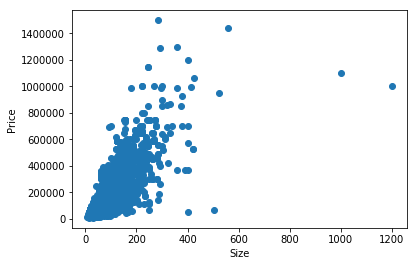

In [73]:
fig, ax = plt.subplots()
ax.scatter(x = data['size'], y = data.price)
plt.ylabel('Price')
plt.xlabel('Size')
plt.show()

In [74]:
# Large prices
data.loc[data.price>1200000]

,advertiser,location,municipality,number_of_rooms,price,size,heating,floor,total_number_of_floors,object_type,filed,balcony,parking,garage,basement
4427,Agencija,Kalenić pijaca,Opština Vračar,5,1288100.0,293.0,CG,6.0,6.0,Novogradnja,False,True,True,True,False
8455,Agencija,Dorćol,Opština Stari grad,5+,1300000.0,360.0,CG,1.0,2.0,Stara gradnja,True,True,False,False,False
9586,Agencija,Vukov Spomenik,Opština Zvezdara,5+,1445000.0,557.0,CG,7.0,8.0,Unknown,False,False,False,False,False
10544,Agencija,Dedinje,Opština Savski venac,5,1500000.0,284.0,CG,1.0,3.0,U izgradnji,False,False,False,False,False


In [75]:
# Small prices, large sizes
data.loc[(data.price<200000)&(data['size']>350)]

,advertiser,location,municipality,number_of_rooms,price,size,heating,floor,total_number_of_floors,object_type,filed,balcony,parking,garage,basement
3463,Agencija,Meljak,Opština Barajevo,5+,53000.0,400.0,EG,0.0,1.0,Stara gradnja,False,False,False,False,False
15938,Agencija,Karaburma,Opština Palilula,2,65000.0,502.0,CG,1.0,8.0,Stara gradnja,False,False,False,False,False


In [76]:
data_for_checking.loc[data_for_checking.location=='Meljak']

,id,accommodation_type,address,advertiser,city,description,location,municipality,number_of_rooms,price,...,balcony,intercom,lift,parking,telephone,internet,katv,garage,basement,loggia
3685,3686,Stan,Veljka Vlahovica,Agencija,Beograd,Kucana dobroj lokaciji. Blizina Robne kuce S...,Meljak,Opština Barajevo,5+,53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [77]:
data.drop([3463], inplace=True) # This is a house, not an appartment (seen from description)
data.drop([15938], inplace=True) # It's url was deleted, so I suppose it was a mistake

In [78]:
data.loc[data['size']>480]

,advertiser,location,municipality,number_of_rooms,price,size,heating,floor,total_number_of_floors,object_type,filed,balcony,parking,garage,basement
8975,Agencija,Dedinje,Opština Savski venac,5+,950000.0,523.0,Podno,0.0,3.0,Novogradnja,True,True,True,True,True
9586,Agencija,Vukov Spomenik,Opština Zvezdara,5+,1445000.0,557.0,CG,7.0,8.0,Unknown,False,False,False,False,False
11143,Agencija,Lekino brdo,Opština Voždovac,5+,1100000.0,1000.0,EG,0.0,5.0,Unknown,False,False,False,False,False
15103,Agencija,Medaković 2,Opština Voždovac,5+,1000000.0,1200.0,EG,0.0,2.0,Unknown,False,False,False,False,False


In [79]:
# Deleting ouliers
data.drop([11143], inplace=True)
data.drop([15103], inplace=True)

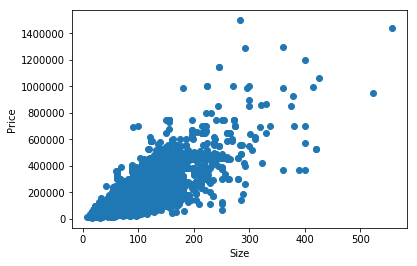

In [80]:
fig, ax = plt.subplots()
ax.scatter(x = data['size'], y = data.price)
plt.ylabel('Price')
plt.xlabel('Size')
plt.show()

In [81]:
# Adjusting order
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

### Making things normal

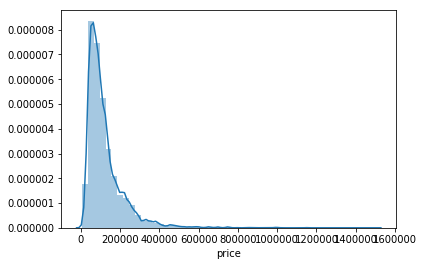

In [82]:
sns.distplot(data.price)
plt.show()

In [83]:
# Skewness and kurtosis
print(data.price.skew())
print(data.price.kurt())

3.2600992524040593
20.270653334470417


Price data is skewed and not symmetric and that's a kind of a problem. Linear regression models assume normality so log function will be applied to achieve normal distribution.

In [84]:
data.price=np.log(data.price)

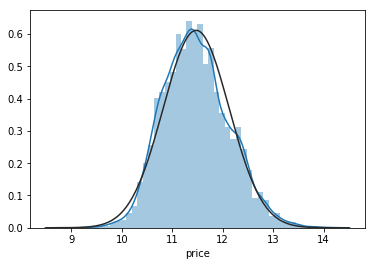

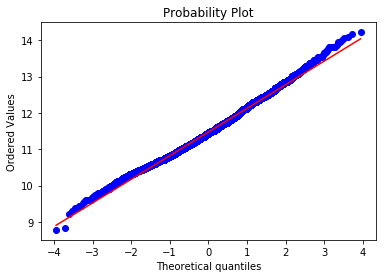

In [85]:
sns.distplot(data.price, fit=norm)
fig=plt.figure()
qqplot=stats.probplot(data.price, plot=plt)
plt.show()

In [86]:
# Skewness and kurtosis after log function
print(data.price.skew())
print(data.price.kurt())

0.2849490531760853
0.03851561541421189


In [87]:
data.describe()

,price,size,floor,total_number_of_floors
count,17128.000000,17128.000000,17128.000000,17128.000000
mean,11.473668,73.955309,2.859762,5.372198
std,0.652592,36.488714,3.181543,3.951864
min,8.779557,8.000000,0.000000,1.000000
25%,11.002100,51.000000,1.000000,3.000000
50%,11.439279,67.000000,2.000000,4.000000
75%,11.884489,88.000000,4.000000,6.000000
max,14.220976,557.000000,29.000000,30.000000


### Checking correlation

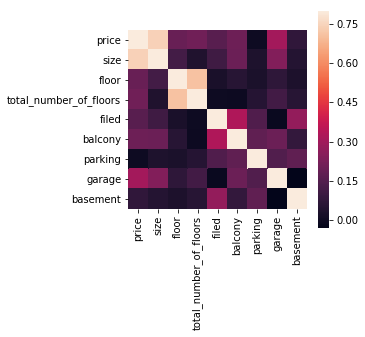

In [88]:
corrmat=data.corr()
f,ax=plt.subplots(figsize=(4,4))
sns.heatmap(corrmat,vmax=.8,square=True)
#plt.xticks(rotation=90)
plt.show()

In [89]:
# categorical columns
bool_cols= ['filed', 'balcony', 'parking', 'garage', 'basement']

# object columns
low_cardinality_cols= ['advertiser', 'heating']
high_cardinality_cols=['location','municipality','number_of_rooms']

# numerical columns
numerical_cols=['price','size','floor','total_number_of_floors']

In [90]:
data.number_of_rooms=data.number_of_rooms.astype(str)

### Applying label encoding to variables with a lot of categories

In [91]:
label_data=data[high_cardinality_cols].copy()
label_data.head()

,location,municipality,number_of_rooms
0,Blok 30 (B92),Opština Novi Beograd,2
1,Blok 22,Opština Novi Beograd,2
2,Blok 67 (Belvil),Opština Novi Beograd,2
3,Blok 67a (A blok),Opština Novi Beograd,3
4,Centar,Opština Savski venac,3.5


In [92]:
label_encoder=LabelEncoder()
for col in high_cardinality_cols:
    label_data[col]=label_encoder.fit_transform(label_data[col])

### Applying OneHot Encoding to variables with small amount of categories

In [93]:
OH_encoder=OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols=pd.DataFrame(OH_encoder.fit_transform(data[low_cardinality_cols]))
OH_cols.index=data.index

### Final data

In [94]:
final_data=pd.concat([data[numerical_cols],label_data,OH_cols,data[bool_cols]],axis=1)
final_data.head()

,price,size,floor,total_number_of_floors,location,municipality,number_of_rooms,0,1,2,...,8,9,10,11,12,filed,balcony,parking,garage,basement
0,11.686879,64.0,1.0,10.0,35,4,3,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,True,False,False,False
1,11.915052,67.0,6.0,6.0,29,4,3,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,True,True,False,True
2,11.820410,60.0,5.0,10.0,53,4,3,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,True,False,False,False
3,12.230765,70.0,4.0,6.0,54,4,5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,True,False,True,False
4,12.409013,113.0,5.0,6.0,71,8,6,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,True,True,False,False,True


In [95]:
final_data.shape

(17128, 25)

### Split data to train and test

In [96]:
cols_to_use=[col for col in final_data.columns if col!='price']
X=final_data[cols_to_use]
y=final_data.price
train_X,test_X,train_y,test_y=train_test_split(X,y,random_state=0)

In [97]:
print(train_X.shape)
print(test_X.shape)

(12846, 24)
(4282, 24)


### Applying regression models

### Linear regression

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model_1 = LinearRegression(normalize=True)
model_1.fit(train_X, train_y)

predictions_1=model_1.predict(test_X)

print('Mean absolute error: ',mean_absolute_error(np.exp(test_y),np.exp(predictions_1)))

# Score should be close to 1
print('Train score: ', model_1.score(train_X, train_y))
print('Test score: ',model_1.score(test_X, test_y))

Mean absolute error:  38857.924012106676
Train score:  0.6427284075246236
Test score:  0.6602455475567948


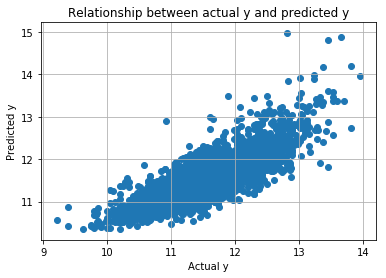

In [99]:
plt.scatter(test_y, predictions_1)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Relationship between actual y and predicted y')
plt.show()

### Support Vector Machine

In [100]:
from sklearn.svm import SVR

model_2=SVR()
model_2.fit(train_X,train_y)

predictions_2=model_2.predict(test_X)
print('Mean absolute error: ',mean_absolute_error(np.exp(test_y),np.exp(predictions_2)))
print('Train score: ',model_2.score(train_X, train_y))
print('Test score: ',model_2.score(test_X, test_y))

Mean absolute error:  24457.496715990863
Train score:  0.9639401008221616
Test score:  0.8053530922815093


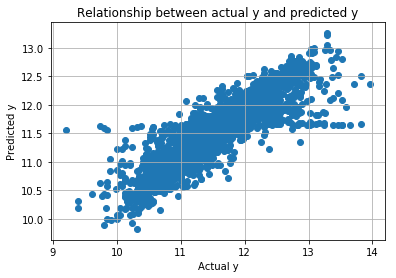

In [101]:
plt.scatter(test_y, predictions_2)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Relationship between actual y and predicted y')
plt.show()

### Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor

model_3=RandomForestRegressor(n_estimators=300, random_state=1)
model_3.fit(train_X,train_y)

predictions_3=model_3.predict(test_X)
print('Mean absolute error: ',mean_absolute_error(np.exp(test_y),np.exp(predictions_3)))
print('Train score: ',model_3.score(train_X, train_y))
print('Test score: ',model_3.score(test_X, test_y))

Mean absolute error:  16084.808056654394
Train score:  0.9878334710751953
Test score:  0.913994718201278


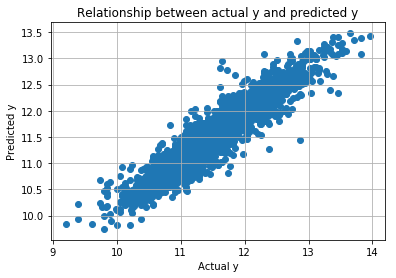

In [103]:
plt.scatter(test_y, predictions_3)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Relationship between actual y and predicted y')
plt.show()

### Gradient Boosting Regressor

In [104]:
from sklearn.ensemble import GradientBoostingRegressor


model_4= GradientBoostingRegressor(n_estimators=1000,
                                  subsample=1.0,
                                  max_depth=3,
                                  learning_rate=0.01,
                                   random_state=1
                                  )
model_4.fit(train_X,train_y)
predictions_4=model_4.predict(test_X)
print('Mean absolute error: ',mean_absolute_error(np.exp(test_y),np.exp(predictions_4)))
print('Train score: ',model_4.score(train_X, train_y))
print('Test score: ',model_4.score(test_X, test_y))

Mean absolute error:  23684.00959888521
Train score:  0.8641609013727787
Test score:  0.8602836402910693


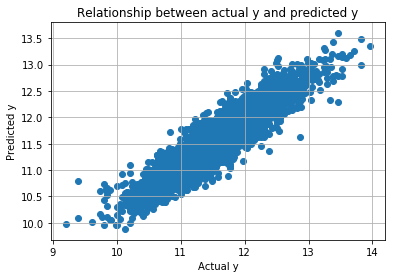

In [105]:
plt.scatter(test_y, predictions_4)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Relationship between actual y and predicted y')
plt.show()

**Random Forest feature importances**

In [106]:
importances =model_3.feature_importances_

feature_list = list(train_X.columns)

feature_results = pd.DataFrame({'feature': feature_list, 'importance': importances})

feature_results= feature_results.sort_values('importance', ascending= False).reset_index(drop=True)

feature_results.head()

,feature,importance
0,size,0.648958
1,municipality,0.148268
2,location,0.072866
3,total_number_of_floors,0.043989
4,floor,0.021456


### Grid Search for Random Forest

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 22.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [108]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [109]:
model_GSearch=RandomForestRegressor(n_estimators=100, min_samples_split=8, min_samples_leaf=3,
                                    max_features=3,max_depth=80,bootstrap=True,
                                    random_state=1)
model_GSearch.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [110]:
predictions_GSearch=model_GSearch.predict(test_X)

In [111]:
print(mean_absolute_error(np.exp(test_y),np.exp(predictions_GSearch)))
print(model_GSearch.score(train_X, train_y))
print(model_GSearch.score(test_X, test_y))

26802.871938471508
0.8595666673051677
0.8196907776024219


Case of overfit.

### Last try with XGBoost

In [112]:
from xgboost import XGBRegressor

model_5= XGBRegressor(n_estimators=3000,
                      max_depth=3,
                      learning_rate=0.1,
                      n_jobs = -1,
                      early_stopping_rounds=10,
                      random_state=1
                                  )
model_5.fit(train_X,train_y)
predictions_5=model_5.predict(test_X)
print('Mean absolute error: ',mean_absolute_error(np.exp(test_y),np.exp(predictions_5)))
print('Train score: ',model_5.score(train_X, train_y))
print('Test score: ',model_5.score(test_X, test_y))

[19:48:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute error:  16846.93735654885
Train score:  0.9544547394681407
Test score:  0.9259349572333139


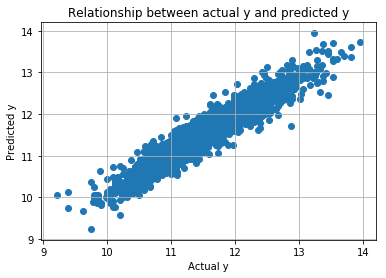

In [113]:
plt.scatter(test_y, predictions_5)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Relationship between actual y and predicted y')
plt.show()

In [114]:
XGB_importances =model_5.feature_importances_

feature_list = list(train_X.columns)

feature_results = pd.DataFrame({'feature': feature_list, 'importance': XGB_importances})

feature_results= feature_results.sort_values('importance', ascending= False).reset_index(drop=True)

feature_results.head()

,feature,importance
0,size,0.262675
1,municipality,0.186706
2,garage,0.135843
3,4,0.127466
4,11,0.048713


XGBoost seams to be the best algorithm, because of the best test score.